In [14]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def normalize_data_X(X):    
    categorical_cols = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]
    encoder = OneHotEncoder(sparse_output=False, drop="first")
    X_encoded = encoder.fit_transform(X[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    X_encoded = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)
    
    numerical_cols = ["Age", "Job", "Credit amount", "Duration"]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X[numerical_cols])
    X_scaled = pd.DataFrame(X_scaled, columns=numerical_cols, index=X.index)
    
    X_preprocessed = pd.concat([X_scaled, X_encoded], axis=1)    
    return X_preprocessed

normalize_data_X_transformer = FunctionTransformer(normalize_data_X, validate=False)

data_X_preparation_pipeline = Pipeline(steps=[
    ("normalization", normalize_data_X_transformer)
])

def normalize_data_y(y):
    y = y.map({'good risk': 0, 'bad risk': 1})
    return y

normalize_data_y_transformer = FunctionTransformer(normalize_data_y, validate=False)

data_y_preparation_pipeline = Pipeline(steps=[
    ("normalization", normalize_data_y_transformer)
])

In [7]:
data = pd.read_csv("data/processed/output_target.csv")
X = data.drop(columns=["target", "description"])
y = data["target"]

In [8]:
X_preprocessed = data_X_preparation_pipeline.fit_transform(X)
y_preprocessed = data_y_preparation_pipeline.fit_transform(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y_preprocessed)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

In [11]:
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print("Resultados de precisión:")
print(results_df)

Resultados de precisión:
                        Accuracy
Support Vector Machine     0.885
Logistic Regression        0.880
Random Forest              0.880
K-Nearest Neighbors        0.865
Decision Tree              0.835


C:\Users\kevin\AppData\Local\Temp\ipykernel_39284\680042463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="viridis")


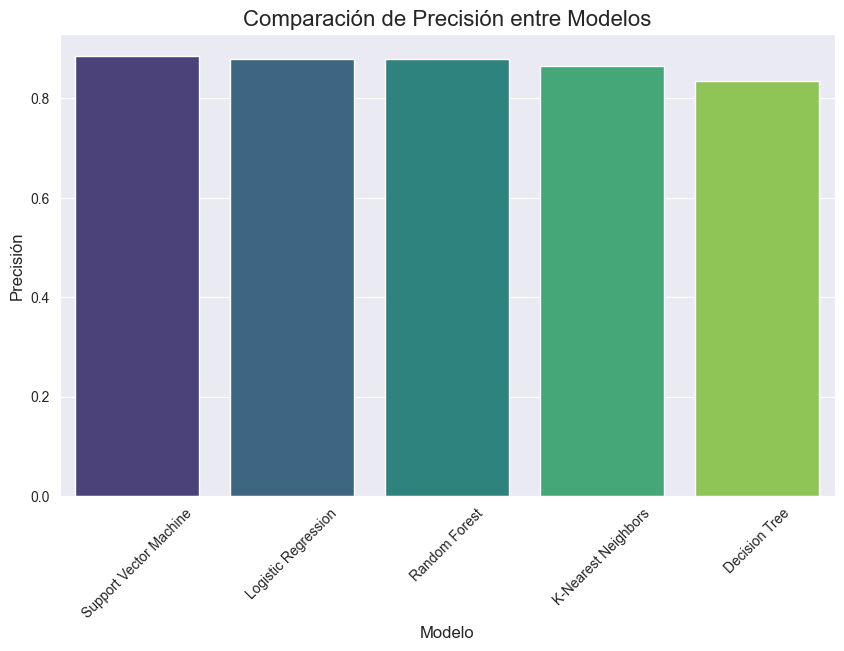

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="viridis")
plt.title("Comparación de Precisión entre Modelos", fontsize=16)
plt.ylabel("Precisión", fontsize=12)
plt.xlabel("Modelo", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [15]:
label_encoders = {}
for column in ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose", "target"]:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le


Informe detallado para el mejor modelo: Support Vector Machine
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       156
           1       0.89      0.55      0.68        44

    accuracy                           0.89       200
   macro avg       0.89      0.76      0.80       200
weighted avg       0.89      0.89      0.87       200


Matriz de Confusión:


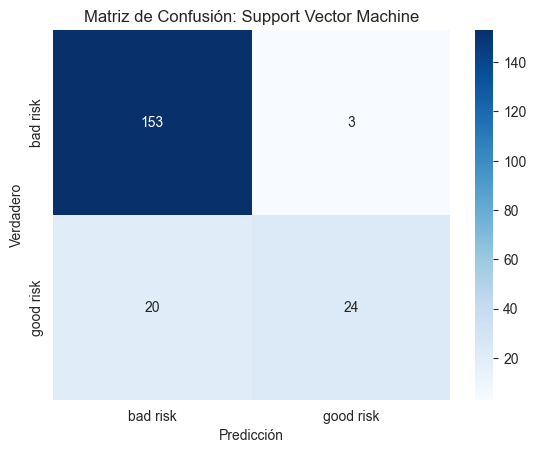

In [16]:
best_model_name = results_df.idxmax().values[0]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

print(f"\nInforme detallado para el mejor modelo: {best_model_name}")
print(classification_report(y_test, y_pred_best))
print("\nMatriz de Confusión:")
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoders["target"].classes_, yticklabels=label_encoders["target"].classes_)
plt.title(f"Matriz de Confusión: {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()